# ANT

In [14]:
import numpy as np
import networkx as nx
import random
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Fonction d'initialisation des phéromones
def initialize_pheromones(G):
    pheromones = {}
    for edge in G.edges():
        pheromones[edge] = 1.0
        pheromones[(edge[1], edge[0])] = 1.0  # Assurer la symétrie
    return pheromones

In [4]:
# Fonction pour calculer la probabilité de transition
def calculate_transition_probabilities(G, pheromones, alpha, beta, current_node, visited):
    probabilities = {}
    total_sum = 0.0
    for neighbor in G.neighbors(current_node):
        if neighbor not in visited:
            distance = G[current_node][neighbor]['weight']
            probabilities[neighbor] = (pheromones[(current_node, neighbor)] ** alpha) * \
                                      ((1.0 / distance) ** beta)
            total_sum += probabilities[neighbor]
    
    if total_sum == 0:
        return None

    for neighbor in probabilities:
        probabilities[neighbor] /= total_sum
    
    return probabilities

In [5]:
# Fonction pour trouver un chemin pour une fourmi
def find_path(G, pheromones, alpha, beta, start_node):
    path = [start_node]
    visited = set(path)
    current_node = start_node
    while len(visited) < len(G.nodes()):
        probabilities = calculate_transition_probabilities(G, pheromones, alpha, beta, current_node, visited)
        if probabilities is None:
            return None
        next_node = random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0]
        path.append(next_node)
        visited.add(next_node)
        current_node = next_node
    path.append(start_node)  # Retourner au point de départ
    return path

In [6]:
# Fonction pour mettre à jour les phéromones
def update_pheromones(G, pheromones, paths, decay):
    for edge in pheromones:
        pheromones[edge] *= (1 - decay)
    for path in paths:
        length = calculate_path_length(G, path)
        for i in range(len(path) - 1):
            from_node = path[i]
            to_node = path[i + 1]
            if (from_node, to_node) in pheromones:
                pheromones[(from_node, to_node)] += 1.0 / length
                pheromones[(to_node, from_node)] += 1.0 / length  # Assurer la symétrie

In [7]:
# Fonction pour calculer la longueur d'un chemin
def calculate_path_length(G, path):
    length = 0
    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i + 1]
        if G.has_edge(from_node, to_node):
            length += G[from_node][to_node]['weight']
        else:
            return float('inf')  # Retourner une longueur infinie si l'arête n'existe pas
    return length

In [8]:
# Fonction principale de l'algorithme
def ant_colony_optimization(G, num_ants, num_iterations, decay, alpha, beta, show_progress=True):
    pheromones = initialize_pheromones(G)
    best_path = None
    best_length = float('inf')
    
    # Sélectionnez la méthode d'itération en fonction du paramètre show_progress
    iterations = tqdm(range(num_iterations), desc="Iterations") if show_progress else range(num_iterations)
    
    for iteration in iterations:
        paths = []
        for _ in range(num_ants):
            start_node = random.choice(list(G.nodes()))
            path = find_path(G, pheromones, alpha, beta, start_node)
            if path is None:
                continue
            length = calculate_path_length(G, path)
            if length == float('inf'):
                continue
            paths.append(path)
            if length < best_length:
                best_length = length
                best_path = path
        update_pheromones(G, pheromones, paths, decay)
        # print(f"Iteration {iteration+1}/{num_iterations}, Best length: {best_length}")
    return best_path, best_length

In [9]:
def brute_force(G):
    nodes = list(G.nodes())
    min_path = None
    min_length = float('inf')
    permutations = list(itertools.permutations(nodes))
    for perm in tqdm(permutations, desc="Calcul naïf"):
        current_length = 0
        valid = True
        # Calculer la longueur du chemin pour cette permutation
        for i in range(len(perm) - 1):
            if G.has_edge(perm[i], perm[i + 1]):
                current_length += G[perm[i]][perm[i + 1]]['weight']
            else:
                valid = False
                break
        if valid and G.has_edge(perm[-1], perm[0]):
            current_length += G[perm[-1]][perm[0]]['weight']
        else:
            valid = False
        # Mettre à jour le chemin minimal si un chemin valide plus court est trouvé
        if valid and current_length < min_length:
            min_length = current_length
            min_path = perm
    if min_path is not None:
        min_path = list(min_path)
        min_path.append(min_path[0])  # Retour au point de départ
    return min_path, min_length

In [10]:
# Extrait du notebook Génération & Visualisation des graphes
# Fonction pour générer un graphe aléatoire
def random_graph(num_nodes):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            weight = random.randint(1, 10)
            G.add_edge(i, j, weight=weight)
    return G

## Code pour la mesure statistique 

In [20]:
def measure_performance(graphs, num_ants, num_iterations, decay, alpha, beta, show_progress=False):
    sizes = []
    times = []
    distances = []
    num_edges = []
    avg_time_per_ant = []
    avg_path_length = []

    for G in tqdm(graphs, desc="Measuring Performance"):
        start_time = time.time()
        best_path, best_length = ant_colony_optimization(G, num_ants, num_iterations, decay, alpha, beta, show_progress)
        end_time = time.time()
        
        execution_time = end_time - start_time
        graph_size = len(G.nodes())
        edge_count = len(G.edges())

        # Mesurer le temps moyen par fourmi
        time_per_ant = execution_time / (num_ants * num_iterations)
        
        # Calculer la longueur moyenne des chemins
        total_path_length = sum(calculate_path_length(G, find_path(G, initialize_pheromones(G), alpha, beta, node)) for node in G.nodes())
        avg_path_len = total_path_length / len(G.nodes())
        
        sizes.append(graph_size)
        times.append(execution_time)
        distances.append(best_length)
        num_edges.append(edge_count)
        avg_time_per_ant.append(time_per_ant)
        avg_path_length.append(avg_path_len)

    # Tracer les résultats
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Temps d'exécution et Distance du meilleur chemin
    ax1 = axes[0, 0]
    ax1.set_xlabel('Taille du graphe')
    ax1.set_ylabel('Temps d\'exécution (s)')
    ax1.plot(sizes, times, label='Temps d\'exécution', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc="upper left")
    
    ax1b = ax1.twinx()
    ax1b.set_ylabel('Distance du meilleur chemin')
    ax1b.plot(sizes, distances, label='Distance du meilleur chemin', color='tab:blue')
    ax1b.tick_params(axis='y', labelcolor='tab:blue')
    ax1b.legend(loc="upper right")

    # Nombre d'arêtes
    ax2 = axes[0, 1]
    ax2.set_xlabel('Taille du graphe')
    ax2.set_ylabel('Nombre d\'arêtes')
    ax2.plot(sizes, num_edges, label='Nombre d\'arêtes', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend(loc="upper left")
    
    # Temps moyen par fourmi
    ax3 = axes[1, 0]
    ax3.set_xlabel('Taille du graphe')
    ax3.set_ylabel('Temps moyen par fourmi (s)')
    ax3.plot(sizes, avg_time_per_ant, label='Temps moyen par fourmi', color='tab:purple')
    ax3.tick_params(axis='y', labelcolor='tab:purple')
    ax3.legend(loc="upper left")
    
    # Longueur moyenne des chemins
    ax4 = axes[1, 1]
    ax4.set_xlabel('Taille du graphe')
    ax4.set_ylabel('Longueur moyenne des chemins')
    ax4.plot(sizes, avg_path_length, label='Longueur moyenne des chemins', color='tab:orange')
    ax4.tick_params(axis='y', labelcolor='tab:orange')
    ax4.legend(loc="upper left")

    fig.tight_layout()
    plt.suptitle('Performance de l\'optimisation par colonie de fourmis', y=1.02)
    plt.show()

Measuring Performance: 100%|███████████████████████████████████████████████████████████| 28/28 [24:32<00:00, 52.60s/it]


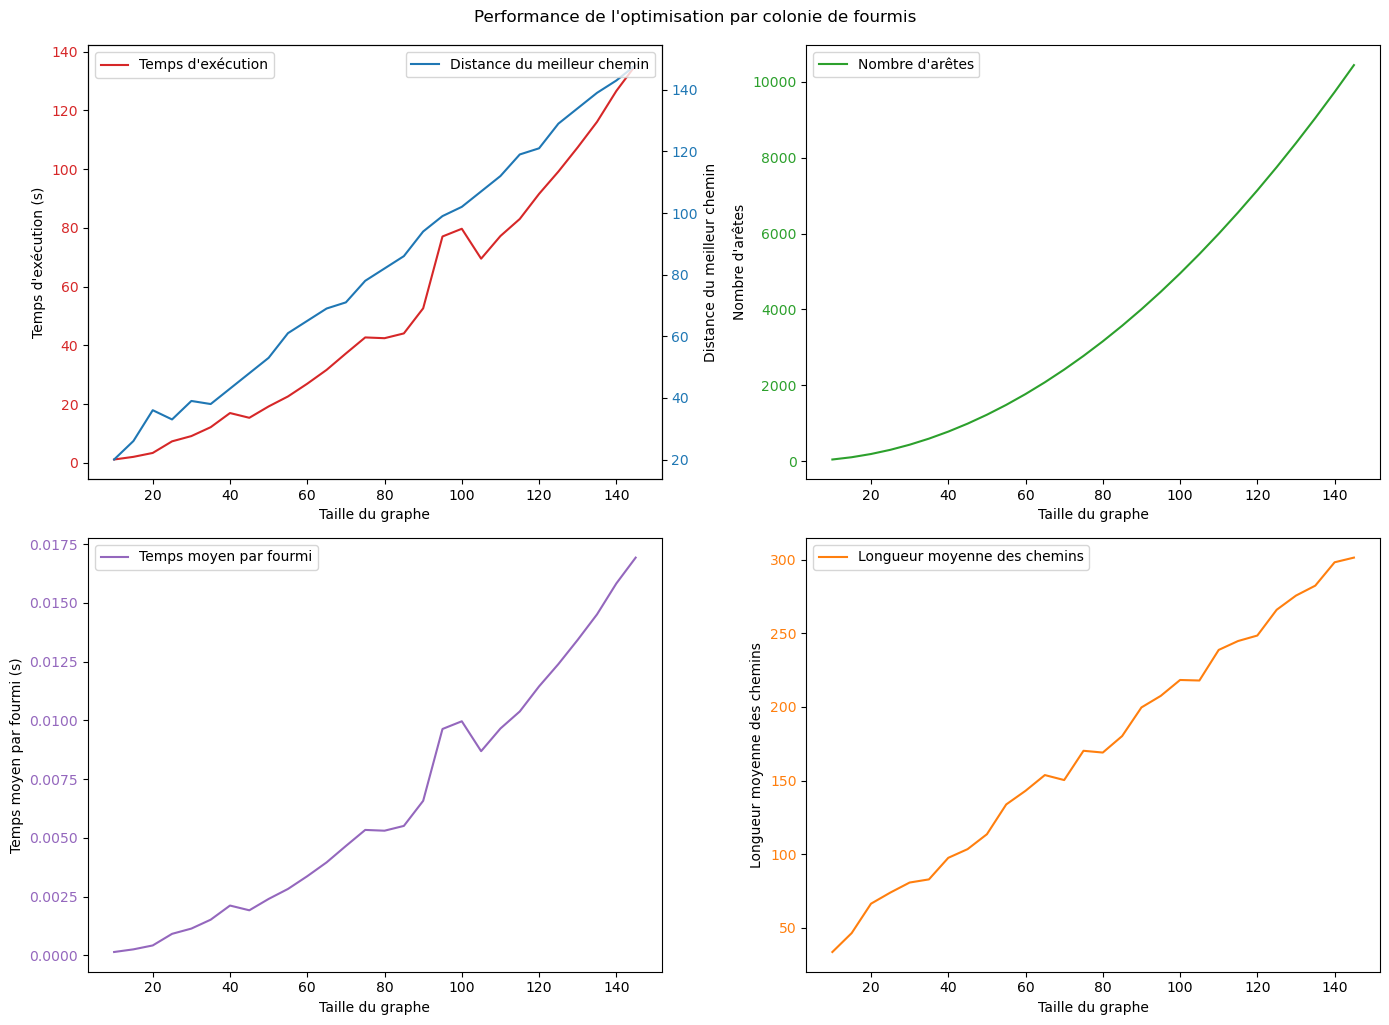

In [23]:
# Exemple d'utilisation
# Paramètres de l'algorithme
num_ants = 80
num_iterations = 100
decay = 0.5
alpha = 1
beta = 2

graphs = [random_graph(size) for size in range(10, 150, 5)]  # Créer des graphes de tailles différentes
measure_performance(graphs, num_ants, num_iterations, decay, alpha, beta, show_progress=False)